In [186]:
import tweepy
import json
import matplotlib.pyplot as plt
import math

api_key = "aJTgi4d1H1zmQNkQuHeualNhP"
api_secrets = "yPFdp2Bbib25r1iPQCqBuPq8B9UzoJbIdpv1jgzEZFEg1eJl6X"
access_token = "1409382627124019204-oPpzVGuCwyFfQTfoocFhgHi68whhog"
access_secret = "esgwpH5gnRfNB0SpiHkO52mZSI5VKKnn8SG2pafEnzj2b"
 
# Authenticate to Twitter
auth = tweepy.OAuthHandler(api_key,api_secrets)
auth.set_access_token(access_token,access_secret)
 
api = tweepy.API(auth)

TWEET_OBJECT_PATH = 'tweet-objects/'

 
try:
    api.verify_credentials()
    print('Successful Authentication')
except:
    print('Failed Authentication')

Successful Authentication


In [187]:
def get_ids(filename):
    with open(filename) as f:
        tweet_ids = f.readlines()

    source_ids = []
    reply_ids_dict = {}
    for i in range(len(tweet_ids)):
        all_ids = tweet_ids[i].split(",")
        for i in range(len(all_ids)):
            all_ids[i] = all_ids[i].replace("\n","")
        source_id = all_ids[0]
        source_ids.append(source_id)
        if len(all_ids) > 1:
            source_id = source_id.replace("\n","")
            reply_ids_dict[source_id] = all_ids[1:]

    return source_ids, reply_ids_dict

def get_labels(filename):    
    with open(filename) as f:
        tweet_labels = f.readlines()

    source_labels = []
    for i in range(len(tweet_labels)):
        label = tweet_labels[i]
        label = label.replace("\n","")
        source_labels.append(label)

    return source_labels

In [188]:
train_source_ids, train_reply_ids = get_ids('train.data.txt')
train_source_labels = get_labels('train.label.txt')

dev_source_ids, dev_reply_ids = get_ids('dev.data.txt')
dev_source_labels = get_labels('dev.label.txt')

test_source_ids, test_reply_ids = get_ids('test.data.txt')

In [189]:
import pandas as pd
import numpy as np

def create_df_and_dict(source_ids, source_labels):
    source_dict = {}
    for i in range(len(source_ids)):
        source_dict[source_ids[i]] = source_labels[i]

    df = pd.DataFrame(source_labels,source_ids)
    df.set_axis(['class'], axis='columns', inplace=True)
    return df, source_dict
    
train_df, train_dict = create_df_and_dict(train_source_ids, train_source_labels)
dev_df, dev_dict = create_df_and_dict(dev_source_ids, dev_source_labels)
train_df

,class
1250219300389974016,nonrumour
554886875303780352,rumour
1237901309011021825,nonrumour
524958128392376320,nonrumour
1239295488677085185,nonrumour
...,...
671181758692507648,rumour
672513234419638273,rumour
553508098825261056,nonrumour
1249479605582327808,nonrumour


In [190]:
api.lookup_statuses(['213321', '23231'],tweet_mode = "extended", map=True)[1].full_text

'RayreadRay - see what you mean about needing it tucked in - good grief...'

In [191]:
def get_tweets(source_ids):
    source_tweets = {}

    source_ids_split = [source_ids[x:x+100] for x in range(0, len(source_ids), 100)]

    for i in range(len(source_ids_split)):
        for tweet in api.lookup_statuses(source_ids_split[i],tweet_mode = "extended"):
            source_tweets[tweet.id_str] = tweet
        
    return source_tweets

def get_test_tweets(source_ids):
    source_tweets = {}

    source_ids_split = [source_ids[x:x+100] for x in range(0, len(source_ids), 100)]

    for i in range(len(source_ids_split)):
        for index, tweet in enumerate(api.lookup_statuses(source_ids_split[i],tweet_mode = "extended", map=True)):
            # Tries to get extended tweet otherwise uses tweet object to create tweet data
            try:
                tweet.full_text
                source_tweets[tweet.id_str] = tweet

            except:
                file = open(TWEET_OBJECT_PATH + str(tweet.id) + '.json')
                tweet = json.load(file)
                source_tweets[tweet['id']] = tweet
 
    return source_tweets

train_source_tweets = get_tweets(train_source_ids) 
dev_source_tweets = get_tweets(dev_source_ids)
test_source_tweets = get_test_tweets(test_source_ids)      

**Raw tweet exploration:**

In [192]:

english_count = 0
total_count = len(train_source_tweets)
for tweet in train_source_tweets.values():
    if tweet.lang == 'en':
        english_count +=1

print(str(english_count) + '/' + str(total_count) + " are english tweets")



1540/1555 are english tweets


In [193]:
rumour_tweet_count = 0
for tweet in train_source_labels:
    if tweet == 'rumour':
        rumour_tweet_count += 1
print(str(rumour_tweet_count) + " out of " + str(len(train_source_labels)) + " are rumours.")

420 out of 1895 are rumours.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


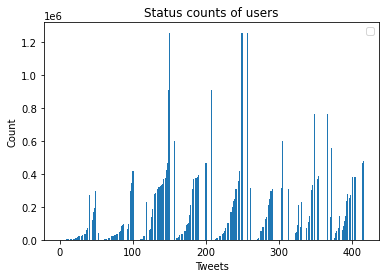

In [194]:
fig, ax = plt.subplots()
ax.bar(range(len(status_count)), status_count)
ax.set_title("Status counts of users")
ax.set_ylabel("Count")
ax.set_xlabel("Tweets")
ax.legend() 

In [195]:
def create_df2(source_tweets):
    tweet_text = []
    tweet_user = []
    tweet_verified = []
    tweet_follows = []
    tweet_hashtag = []
    tweet_user_statuses_count = []
    
    for tweet in source_tweets.values():
        if type(tweet) is dict:
            tweet_text.append(tweet['text'])
            tweet_user.append(tweet['user']['screen_name'])
            tweet_verified.append(tweet['user']['verified'])
            tweet_follows.append(tweet['user']['followers_count'])
            tweet_user_statuses_count.append(tweet['user']['statuses_count'])
            if tweet['entities']['hashtags'] == []:
                tweet_hashtag.append("")
            else:
                tweet_hashtag.append(tweet['entities']['hashtags'][0]['text'])
        else:
            tweet_text.append(tweet.full_text)
            
            tweet_user.append(tweet.user.screen_name)
            tweet_verified.append(tweet.user.verified)
            tweet_follows.append(tweet.user.followers_count)
            tweet_user_statuses_count.append(tweet.user.statuses_count)
            if tweet.entities['hashtags'] == []:
                tweet_hashtag.append("")
            else:
                tweet_hashtag.append(tweet.entities['hashtags'][0]['text'])
   

    df2 = pd.DataFrame({'user':tweet_user,
                        'verified':tweet_verified,
                        'followers':tweet_follows,
                        'text': tweet_text,
                        'statuses_count': tweet_user_statuses_count,
                        'hashtag': tweet_hashtag},index=list(source_tweets.keys()))
    #df2['text_trimmed'] = df2['text'].str[:50]
    #df2.drop_duplicates(subset=['text_trimmed'],keep='first',inplace=True)

    return df2

    
train_df2 = create_df2(train_source_tweets)
dev_df2 = create_df2(dev_source_tweets)
test_df2 = create_df2(test_source_tweets)


In [196]:
def create_final_df(df1, df2):
    df_source = df1.join(df2)
    cols = df_source.columns.tolist()
    df_source = df_source[cols[1:8]+cols[0:1]]
    return df_source

train_final_df = create_final_df(train_df, train_df2)
dev_final_df = create_final_df(dev_df, dev_df2)

In [199]:
r_status_average= train_final_df[train_final_df['class'] == 'rumour'].statuses_count.mean()


nr_status_average = train_final_df[train_final_df['class'] == 'nonrumour'].statuses_count.mean()


r_status_average

197362.51886792452

Text(0.5, 0, 'Label')

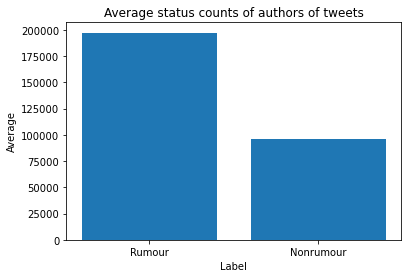

In [204]:
fig, ax = plt.subplots()
ax.bar(['Rumour', 'Nonrumour'], [r_status_average, nr_status_average])
ax.set_title("Average status counts of authors of tweets")
ax.set_ylabel("Average")
ax.set_xlabel("Label")

In [ ]:
rumour_user_counts = train_final_df[train_final_df['class'] == 'rumour'].user.value_counts()
rumour_user_counts

Fact           7
BuzzFeed       6
ABC            6
Independent    6
CNN            5
              ..
dbongino       1
hale_razor     1
th3j35t3r      1
DanJoseph78    1
WashTimes      1
Name: user, Length: 246, dtype: int64

In [ ]:
nonrumour_user_counts = train_final_df[train_final_df['class'] == 'nonrumour'].user.value_counts()
nonrumour_user_counts

WHO                22
WHOWPRO            13
FoxNews            11
ucoptempe          10
ABC                10
                   ..
BPolte              1
frankoguaju         1
catlady_chelsea     1
Codeye67            1
nycjim              1
Name: user, Length: 886, dtype: int64

In [ ]:
train_users = train_final_df['user'].unique()
dev_users = dev_final_df['user'].unique()

both_count = 0
for user in dev_users:
    if user in train_users:
        both_count += 1

print(str(both_count) + " of " + str(len(dev_users)) + " users in the dev set are also in the training set.")

133 of 424 users in the dev set are also in the training set.


In [ ]:
def reply_create_lists(reply_ids_dict, source_dict, test):
    reply_source_ids = []
    reply_ids = []
    reply_source_class = []

    for source_id in reply_ids_dict.keys():
        for reply_id in reply_ids_dict[source_id]:
            reply_source_ids.append(source_id)
            reply_ids.append(reply_id)

    if not test:
        for source_id in reply_source_ids:
            reply_source_class.append(source_dict[source_id])
        assert(len(reply_source_ids)==len(reply_ids))
        return reply_source_ids, reply_ids, reply_source_class
    else:
        assert(len(reply_source_ids)==len(reply_ids))
        return reply_source_ids, reply_ids
        

train_reply_source_ids, train_reply_ids2, train_reply_source_class = reply_create_lists(train_reply_ids, train_dict, False)
dev_reply_source_ids, dev_reply_ids2, dev_reply_source_class = reply_create_lists(dev_reply_ids, dev_dict, False)
test_reply_source_ids, test_reply_ids2 = reply_create_lists(test_reply_ids, None, True)

train_reply_source_ids

['1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '1250219300389974016',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '554886875303780352',
 '55488687530378035

In [ ]:
"""
    reply_tweets = {}

    reply_ids_split = [reply_ids[x:x+100] for x in range(0, len(reply_ids), 100)]

    for i in range(len(reply_ids_split)):
        for tweet in api.lookup_statuses(reply_ids_split[i],tweet_mode = "extended"):
            reply_tweets[tweet.id_str] = tweet
"""

train_reply_tweets = get_tweets(train_reply_ids2)
dev_reply_tweets = get_tweets(dev_reply_ids2)
test_reply_tweets = get_test_tweets(test_reply_ids2)
        
train_reply_tweets['554919484473880576']


Status(_api=<tweepy.api.API object at 0x7faaa5a69cd0>, _json={'created_at': 'Tue Jan 13 08:34:49 +0000 2015', 'id': 554919484473880576, 'id_str': '554919484473880576', 'full_text': '@Telegraph we will be very satisfied if #NawazSharif resigns. Here they hide the reports which blames them.', 'truncated': False, 'display_text_range': [0, 107], 'entities': {'hashtags': [{'text': 'NawazSharif', 'indices': [40, 52]}], 'symbols': [], 'user_mentions': [{'screen_name': 'Telegraph', 'name': 'The Telegraph', 'id': 16343974, 'id_str': '16343974', 'indices': [0, 10]}], 'urls': []}, 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'in_reply_to_status_id': 554886875303780352, 'in_reply_to_status_id_str': '554886875303780352', 'in_reply_to_user_id': 16343974, 'in_reply_to_user_id_str': '16343974', 'in_reply_to_screen_name': 'Telegraph', 'user': {'id': 518268340, 'id_str': '518268340', 'name': 'RK', 'screen_name': 'Immorality101', 'location': 'Here and Th

In [ ]:
num_trunc = 0
total = len(train_reply_tweets.keys())
for obj in train_reply_tweets.values():
    if obj.truncated: num_trunc += 1
print(num_trunc/total)

0.0


In [ ]:
def create_reply_df(reply_ids, reply_tweets, reply_source_ids, reply_source_class, test):
    tweet_text = []
    tweet_user = []
    tweet_verified = []
    tweet_follows = []
    tweet_retweets = []
    tweet_favorites = []
    tweet_hashtag = []

    for id in reply_ids:
        try:
            tweet = reply_tweets[id]
        except:
            pass
        if type(tweet) is dict:
            tweet_text.append(tweet['text'])
            tweet_user.append(tweet['user']['screen_name'])
            tweet_verified.append(tweet['user']['verified'])
            tweet_follows.append(tweet['user']['followers_count'])
            tweet_retweets.append(tweet['favorite_count'])
            tweet_retweets.append(tweet['retweet_count'])
            if tweet['entities']['hashtags'] == []:
                tweet_hashtag.append("")
            else:
                tweet_hashtag.append(tweet['entities']['hashtags'][0]['text'])
        else:
            tweet_text.append(tweet.full_text)
            tweet_user.append(tweet.user.screen_name)
            tweet_verified.append(tweet.user.verified)
            tweet_follows.append(tweet.user.followers_count)
            tweet_retweets.append(tweet.retweet_count)
            tweet_favorites.append(tweet.favorite_count)
            if tweet.entities['hashtags'] == []:
                tweet_hashtag.append("")
            else:
                tweet_hashtag.append(tweet.entities['hashtags'][0]['text'])

    if not test:
        df_replies = pd.DataFrame({'user':tweet_user,
                            'verified':tweet_verified,
                            'followers':tweet_follows,
                            'text':tweet_text,
                            'retweets':tweet_retweets,
                            'favorites':tweet_favorites,                                   
                            'hashtag':tweet_hashtag,
                            'source id':reply_source_ids,
                            'source class':reply_source_class,
                            },
                                index=reply_ids)
    else:
        df_replies = pd.DataFrame({'user':tweet_user,
                            'verified':tweet_verified,
                            'followers':tweet_follows,
                            'text':tweet_text,
                            'retweets':tweet_retweets,
                            'favorites':tweet_favorites, 
                            'hashtag':tweet_hashtag,
                            'source id':reply_source_ids,
                            },
                                index=reply_ids)
    
    return df_replies

In [ ]:
train_df_replies = create_reply_df(train_reply_ids2, train_reply_tweets, train_reply_source_ids, train_reply_source_class, False)
dev_df_replies = create_reply_df(dev_reply_ids2, dev_reply_tweets, dev_reply_source_ids, dev_reply_source_class, False)
test_df_replies = create_reply_df(test_reply_ids2, test_reply_tweets, test_reply_source_ids, None, True)
train_df_replies    

,user,verified,followers,text,retweets,favorites,hashtag,source id,source class
1250219116993974272,ucoptempe,False,411,4. Can eating garlic help prevent infection wi...,0,0,COVID19Malaysia,1250219300389974016,nonrumour
1250219437027766273,ucoptempe,False,411,6. Do vaccines against pneumonia protect you a...,0,0,,1250219300389974016,nonrumour
1250219620939657216,ucoptempe,False,411,7. Can spraying alcohol or chlorine all over y...,0,0,Chamber,1250219300389974016,nonrumour
1250219777185873922,ucoptempe,False,411,8. How effective are thermal scanners in detec...,0,0,,1250219300389974016,nonrumour
1250219894429208577,ucoptempe,False,411,9. Can an ultraviolet disinfection lamp kill t...,0,0,,1250219300389974016,nonrumour
...,...,...,...,...,...,...,...,...,...
1241078443179155457,lynneSimpkin,False,562,@rosierawle All good. Just been working out th...,0,1,,1241082793737818113,nonrumour
1241085785060847617,lynneSimpkin,False,562,@rosierawle Best timetable I've heard about! A...,0,1,,1241082793737818113,nonrumour
1241086391267872770,rosierawle,False,3103,@lynneSimpkin And this exactly why you need to...,0,1,,1241082793737818113,nonrumour
1241086505566732289,lynneSimpkin,False,562,@rosierawle I might have sent that twice by ac...,0,1,,1241082793737818113,nonrumour


In [ ]:
train_final_df

,user,verified,followers,text,hashtag,class
1218255692831903744,WHO,True,11154137.0,Q: Is there a treatment for a novel #coronavir...,coronavirus,nonrumour
1218269428166602753,WHO,True,11154137.0,Q: What can I do to protect myself from #coron...,coronavirus,nonrumour
1219979825848442880,WHO,True,11152323.0,@DrTedros @WHOWPRO @WHOSEARO @pahowho @WHOEMRO...,coronavirus,nonrumour
1219981282928668672,WHO,True,11154137.0,@DrTedros @WHOWPRO @WHOSEARO @pahowho @WHOEMRO...,coronavirus,nonrumour
1219982106757148673,WHO,True,11154137.0,@DrTedros @WHOWPRO @WHOSEARO @pahowho @WHOEMRO...,coronavirus,nonrumour
...,...,...,...,...,...,...
676718762830221312,Complex,True,2573534.0,Texas plumber sues car dealership after his tr...,,rumour
676870737932742656,ABC,True,17459938.0,Plumber suing car dealership for $1M after tru...,,rumour
677099574855639044,ABC,True,17459938.0,Plumber suing car dealership for $1M after tru...,,rumour
681767380305985536,mashable,True,9428319.0,"Sorry, Mark Zuckerberg is not giving $4.5 bill...",,rumour


In [ ]:
train_final_df.index.name = 'id'
train_df_replies.index.name = 'id'
train_final_df.dropna(subset=['text'],inplace=True)
train_df_replies.dropna(subset=['text'],inplace=True)


In [ ]:
dev_final_df.index.name = 'id'
dev_df_replies.index.name = 'id'
dev_final_df.dropna(subset=['text'],inplace=True)
dev_df_replies.dropna(subset=['text'],inplace=True)


In [ ]:
test_df2.index.name = 'id'
test_df_replies.index.name = 'id'
test_df2.dropna(subset=['text'],inplace=True)
test_df_replies.dropna(subset=['text'],inplace=True)
